In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv(r"C:\Users\dell\Downloads\GOOG.csv")  

In [3]:
df.isnull().sum()

symbol         0
date           0
close          0
high           0
low            0
open           0
volume         0
adjClose       0
adjHigh        0
adjLow         0
adjOpen        0
adjVolume      0
divCash        0
splitFactor    0
dtype: int64

In [4]:
df = df[['date', 'close']]
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
df

,close
date,
2016-06-14 00:00:00+00:00,718.27
2016-06-15 00:00:00+00:00,718.92
2016-06-16 00:00:00+00:00,710.36
2016-06-17 00:00:00+00:00,691.72
2016-06-20 00:00:00+00:00,693.71
...,...
2021-06-07 00:00:00+00:00,2466.09
2021-06-08 00:00:00+00:00,2482.85
2021-06-09 00:00:00+00:00,2491.40


In [6]:

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['close']])

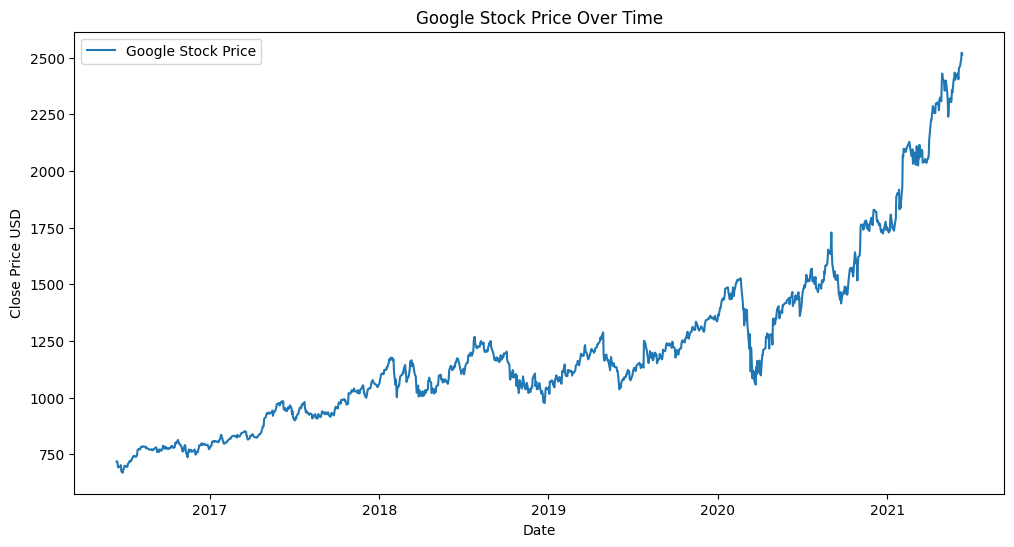

In [7]:
# Visualize the closing price
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Google Stock Price')
plt.title('Google Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()

In [8]:
# Create sequences for lstm
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

In [9]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Train the model
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20

30/30 [==============================] - 4s 37ms/step - loss: 0.0184 - val_loss: 0.0590
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0152
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 8.3010e-04 - val_loss: 0.0016
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 5.4838e-04 - val_loss: 0.0016
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 5.1106e-04 - val_loss: 0.0019
Epoch 6/20
30/30 [==============================] - 1s 21ms/step - loss: 5.0597e-04 - val_loss: 0.0014
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 4.6853e-04 - val_loss: 0.0015
Epoch 8/20
30/30 [==============================] - 1s 21ms/step - loss: 4.4983e-04 - val_loss: 0.0013
Epoch 9/20
30/30 [==============================] - 1s 21ms/step - loss: 4.2766e-04 - val_loss: 0.0014
Epoch 10/20
30/30 [==============================] - 1s 21ms/step - loss: 4.1523

In [12]:
# Predict
y_pred = model.predict(X_test)

8/8 [==============================] - 1s 7ms/step


In [13]:
# Inverse scale predictions
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Evaluation
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100

print(f"\n📈 Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


📈 Evaluation Metrics:
Mean Absolute Error (MAE): 74.13
Root Mean Squared Error (RMSE): 91.69
R² Score: 0.9174
Mean Absolute Percentage Error (MAPE): 3.85%


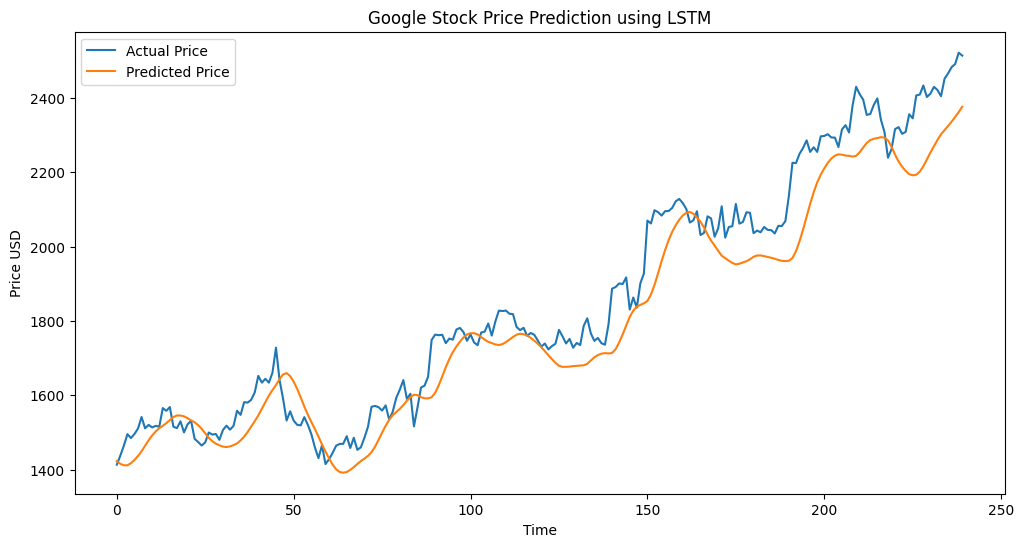

In [15]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Price')
plt.plot(y_pred_rescaled, label='Predicted Price')
plt.title('Google Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price USD')
plt.legend()
plt.show()